# Operational Load Hotspots

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 150          # display resolution
plt.rcParams["savefig.dpi"] = 300         # saved image quality

## Load Datasets

In [4]:
ENROL1_PATH = 'api_data_aadhar_enrolment/api_data_aadhar_enrolment_0_500000.csv'
ENROL2_PATH = 'api_data_aadhar_enrolment/api_data_aadhar_enrolment_500000_1000000.csv'
ENROL3_PATH = 'api_data_aadhar_enrolment/api_data_aadhar_enrolment_1000000_1006029.csv'

DEMO1_PATH = 'api_data_aadhar_demographic/api_data_aadhar_demographic_0_500000.csv'
DEMO2_PATH = 'api_data_aadhar_demographic/api_data_aadhar_demographic_500000_1000000.csv'
DEMO3_PATH = 'api_data_aadhar_demographic/api_data_aadhar_demographic_1000000_1500000.csv'
DEMO4_PATH = 'api_data_aadhar_demographic/api_data_aadhar_demographic_1500000_2000000.csv'
DEMO5_PATH = 'api_data_aadhar_demographic/api_data_aadhar_demographic_2000000_2071700.csv'

BIO1_PATH = 'api_data_aadhar_biometric/api_data_aadhar_biometric_0_500000.csv'
BIO2_PATH = 'api_data_aadhar_biometric/api_data_aadhar_biometric_500000_1000000.csv'
BIO3_PATH = 'api_data_aadhar_biometric/api_data_aadhar_biometric_1000000_1500000.csv'
BIO4_PATH = 'api_data_aadhar_biometric/api_data_aadhar_biometric_1500000_1861108.csv'

In [5]:
enrol1= pd.read_csv(ENROL1_PATH)
enrol2= pd.read_csv(ENROL2_PATH)
enrol3= pd.read_csv(ENROL3_PATH)

demo1= pd.read_csv(DEMO1_PATH)
demo2= pd.read_csv(DEMO2_PATH)
demo3= pd.read_csv(DEMO3_PATH)
demo4= pd.read_csv(DEMO4_PATH)
demo5= pd.read_csv(DEMO5_PATH)

bio1= pd.read_csv(BIO1_PATH)
bio2= pd.read_csv(BIO2_PATH)
bio3= pd.read_csv(BIO3_PATH)
bio4= pd.read_csv(BIO4_PATH)

## Minimal Cleaning & Alignment

In [6]:
enrol= pd.concat([enrol1, enrol2, enrol3], ignore_index= True)

In [7]:
demo= pd.concat([demo1, demo2, demo3, demo4, demo5], ignore_index= True)
bio= pd.concat([bio1, bio2, bio3, bio4], ignore_index= True)

## Date Processing

In [8]:
enrol['date'] = pd.to_datetime(enrol['date'], format='%d-%m-%Y')
enrol['month'] = enrol['date'].dt.to_period('M')

demo['date'] = pd.to_datetime(demo['date'], format='%d-%m-%Y')
demo['month'] = demo['date'].dt.to_period('M')

bio['date'] = pd.to_datetime(bio['date'], format='%d-%m-%Y')
bio['month'] = bio['date'].dt.to_period('M')

## Feature Engineering

In [9]:
enrol["total_enrolments"] = (
    enrol["age_0_5"] +
    enrol["age_5_17"] +
    enrol["age_18_greater"]
)

In [10]:
demo["demo_activity"] = (
    demo["demo_age_5_17"] +
    demo["demo_age_17_"]
)
bio["bio_activity"] = (
    bio["bio_age_5_17"] +
    bio["bio_age_17_"]
)

## Calculate Monthly Volatility (Consistency Check)

In [11]:
monthly_demo = (
    demo.groupby(['state', 'district', 'pincode', 'month'], as_index=False)
        ['demo_activity'].sum()
)

monthly_bio = (
    bio.groupby(['state', 'district', 'pincode', 'month'], as_index=False)
       ['bio_activity'].sum()
)

monthly_load = monthly_demo.merge(
    monthly_bio,
    on=['state', 'district', 'pincode', 'month'],
    how='outer'
)
monthly_load.fillna(0, inplace=True)

monthly_load['monthly_total'] = (
    monthly_load['demo_activity'] +
    monthly_load['bio_activity']
)

In [12]:
consistency_metrics = (
    monthly_load.groupby(['state', 'district', 'pincode'])['monthly_total']
                .agg(['mean', 'std'])
                .reset_index()
)

consistency_metrics.rename(
    columns={'mean': 'avg_monthly_load', 'std': 'load_volatility'},
    inplace=True
)

consistency_metrics['load_volatility'].fillna(0, inplace=True)

/var/folders/25/r3qddc3s27sf_19gdvyt4xfw0000gn/T/ipykernel_36544/1590041440.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  consistency_metrics['load_volatility'].fillna(0, inplace=True)


## Aggregate at Pincode Level

In [13]:
enrol_pin = (
    enrol.groupby(["state", "district", "pincode"], as_index=False)
         ["total_enrolments"]
         .sum()
)

demo_pin = (
    demo.groupby(["state", "district", "pincode"], as_index=False)
        ["demo_activity"]
        .sum()
)

bio_pin = (
    bio.groupby(["state", "district", "pincode"], as_index=False)
       ["bio_activity"]
       .sum()
)

## Merge Datasets

In [14]:
pincode_df = (
    enrol_pin
    .merge(demo_pin, on=["state", "district", "pincode"], how="left")
    .merge(bio_pin, on=["state", "district", "pincode"], how="left")
    .merge(consistency_metrics, on=["state", "district", "pincode"], how="left")
)

pincode_df.fillna(0, inplace=True)

In [15]:
pincode_df.head()

,state,district,pincode,total_enrolments,demo_activity,bio_activity,avg_monthly_load,load_volatility
0,100000,100000,100000,218,2.0,0.0,2.000000,0.000000
1,Andaman & Nicobar Islands,Andamans,744101,9,303.0,1324.0,180.777778,62.265114
2,Andaman & Nicobar Islands,Andamans,744103,25,148.0,215.0,90.750000,30.346609
3,Andaman & Nicobar Islands,Andamans,744105,22,136.0,200.0,84.000000,17.682383
4,Andaman & Nicobar Islands,Andamans,744106,5,66.0,162.0,45.600000,10.549882


## Compute Operational Load

In [16]:
pincode_df["total_activity"] = (
    pincode_df["total_enrolments"] +
    pincode_df["demo_activity"] +
    pincode_df["bio_activity"]
)
pincode_df["activity_per_enrolment"] = (
    pincode_df["total_activity"] /
    pincode_df["total_enrolments"].replace(0, np.nan)
)

## Aggregate to District Level (for Hotspot Identification)

In [17]:
district_df = (
    pincode_df.groupby(["state", "district"], as_index=False)
              .agg({
                  "total_enrolments": "sum",
                  "demo_activity": "sum",
                  "bio_activity": "sum",
                  "total_activity": "sum",
                  "avg_monthly_load": "mean",
                  "load_volatility": "mean"
              })
)

district_df["activity_per_enrolment"] = (
    district_df["total_activity"] /
    district_df["total_enrolments"].replace(0, np.nan)
)

## Identify Hotspots

In [18]:
threshold = district_df["total_activity"].quantile(0.90)

hotspots = district_df[
    district_df["total_activity"] >= threshold
].sort_values("total_activity", ascending=False)

In [19]:
hotspots.head()

,state,district,total_enrolments,demo_activity,bio_activity,total_activity,avg_monthly_load,load_volatility,activity_per_enrolment
563,Maharashtra,Pune,31763,438439.0,605739.0,1075941.0,789.983112,400.174077,33.874036
572,Maharashtra,Thane,43688,447187.0,571210.0,1062085.0,1250.990011,575.505635,24.310680
559,Maharashtra,Nashik,22368,246083.0,576588.0,845039.0,1203.039291,611.876938,37.778925
234,Gujarat,Ahmedabad,19130,267868.0,405479.0,692477.0,870.844998,422.798111,36.198484
266,Gujarat,Surat,25469,357575.0,281583.0,664627.0,800.551190,474.841533,26.095528


## Visualization: Top Load Districts

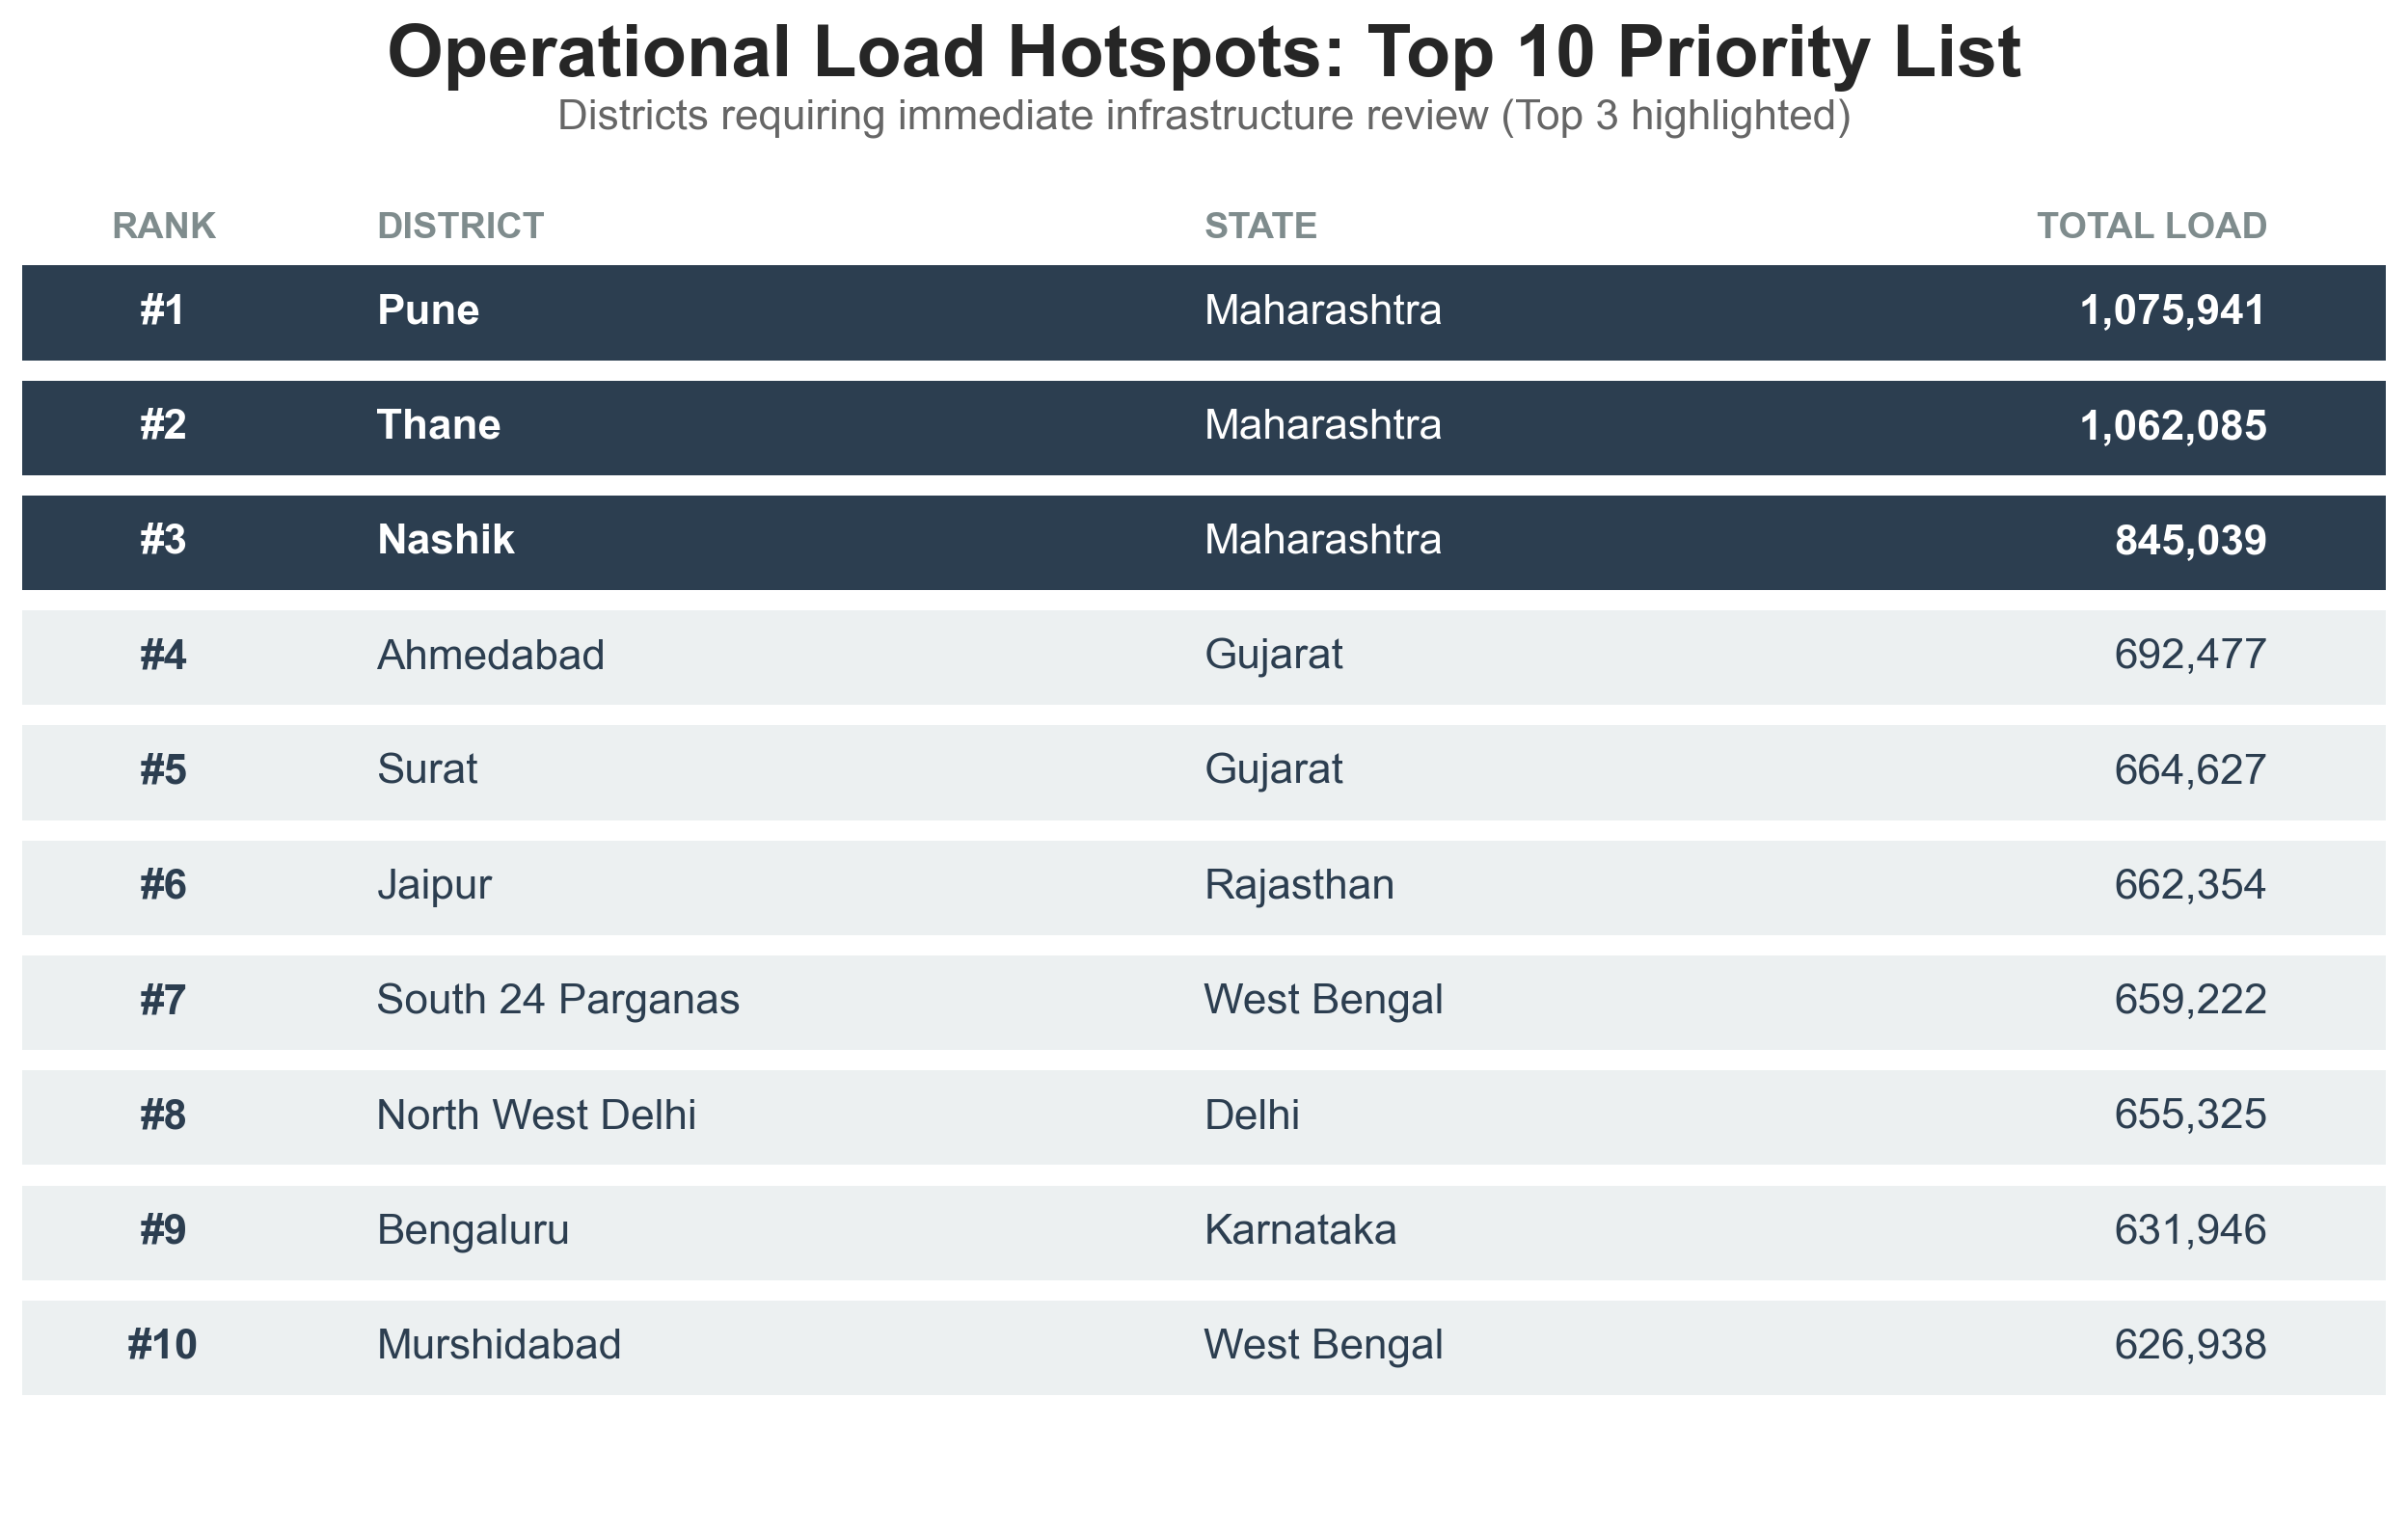

In [39]:
import matplotlib.patches as patches

# 1. Prepare Data for Table
top10_table = hotspots.head(10).copy().reset_index(drop=True)
top10_table["rank"] = top10_table.index + 1

# 2. Setup Plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=227)
ax.set_xlim(0, 1)
ax.set_ylim(0, 11) 
ax.axis('off')

# 3. Define Layout & Colors
colors = {
    'top3_bg': '#2c3e50',   # Dark Slate Blue/Grey
    'top3_text': 'white',
    'rest_bg': '#ecf0f1',   # Very Light Grey
    'rest_text': '#2c3e50',
    'header_text': '#7f8c8d'
}

# 4. Draw Header
header_y = 9.4

plt.text(0.06, header_y, "RANK", weight='bold', size=12, color=colors['header_text'], ha='center')
plt.text(0.15, header_y, "DISTRICT", weight='bold', size=12, color=colors['header_text'], ha='left')
plt.text(0.50, header_y, "STATE", weight='bold', size=12, color=colors['header_text'], ha='left')
plt.text(0.95, header_y, "TOTAL LOAD", weight='bold', size=12, color=colors['header_text'], ha='right')

# 5. Loop to Draw Rows
start_y = 9.0 

for idx, row in top10_table.iterrows():
    # Determine Style
    if idx < 3: 
        bg_color = colors['top3_bg']
        txt_color = colors['top3_text']
        font_weight = 'bold'
    else:       
        bg_color = colors['rest_bg']
        txt_color = colors['rest_text']
        font_weight = 'normal'
    
    # Draw Row Background
    rect = patches.Rectangle((0, start_y - 0.5), 1, 0.7, linewidth=0, facecolor=bg_color)
    ax.add_patch(rect)
    
    # Add Text Data
    plt.text(0.06, start_y - 0.15, f"#{row['rank']}", 
             size=14, color=txt_color, weight='bold', ha='center', va='center')
    
    plt.text(0.15, start_y - 0.15, row['district'], 
             size=14, color=txt_color, weight=font_weight, ha='left', va='center')
    
    plt.text(0.50, start_y - 0.15, row['state'], 
             size=14, color=txt_color, weight='normal', ha='left', va='center')
    
    plt.text(0.95, start_y - 0.15, f"{int(row['total_activity']):,}", 
             size=14, color=txt_color, weight=font_weight, ha='right', va='center')
    
    # Move down for next row
    start_y -= 0.85

# 6. Titles (Now Center Aligned)
plt.text(0.5, 10.6, "Operational Load Hotspots: Top 10 Priority List", 
         fontsize=24, weight='bold', ha='center')

plt.text(0.5, 10.2, "Districts requiring immediate infrastructure review (Top 3 highlighted)", 
         fontsize=14, color='#666666', ha='center')

# 7. Layout Adjustments
plt.subplots_adjust(top=0.90, bottom=0.05, left=0.05, right=0.95)
plt.show()

## Insight: Operational Load Hotspots

### Certain districts exhibit disproportionately high Aadhaar activity when enrolment, demographic activity, and biometric activity are combined.

These hotspots represent regions where:
- Service demand is consistently high
- Infrastructure and staffing pressure is likely concentrated
- Proactive resource planning can reduce citizen friction

This insight is derived purely from aggregated activity patterns and does not rely
on individual-level behavior or assumptions.

# Pincode-Level Drill-Down

In [21]:
top10_districts = (
    district_df
    .sort_values("total_activity", ascending=False)
    .head(10)[["state", "district"]]
)

top10_districts

,state,district
563,Maharashtra,Pune
572,Maharashtra,Thane
559,Maharashtra,Nashik
234,Gujarat,Ahmedabad
266,Gujarat,Surat
771,Rajasthan,Jaipur
1057,West Bengal,South 24 Parganas
224,Delhi,North West Delhi
397,Karnataka,Bengaluru
1044,West Bengal,Murshidabad


In [22]:
pincode_top = pincode_df.merge(
    top10_districts,
    on=["state", "district"],
    how="inner"
)

In [23]:
pincode_top.head()

,state,district,pincode,total_enrolments,demo_activity,bio_activity,avg_monthly_load,load_volatility,total_activity,activity_per_enrolment
0,Delhi,North West Delhi,110009,391,6953.0,7651.0,1622.666667,789.627285,14995.0,38.350384
1,Delhi,North West Delhi,110033,1018,42248.0,28100.0,7816.444444,4840.526291,71366.0,70.104126
2,Delhi,North West Delhi,110034,2318,30665.0,14512.0,5019.666667,3439.683779,47495.0,20.489646
3,Delhi,North West Delhi,110035,316,8003.0,7740.0,1749.222222,733.758267,16059.0,50.819620
4,Delhi,North West Delhi,110036,483,8362.0,11753.0,2235.000000,1442.143543,20598.0,42.645963


## Compute Pincode Share Within District

In [24]:
pincode_top["district_total_activity"] = (
    pincode_top.groupby(["state", "district"])["total_activity"]
               .transform("sum")
)

pincode_top["pincode_activity_share"] = (
    pincode_top["total_activity"] /
    pincode_top["district_total_activity"]
)

## Identify Pincode "Gravity Points"

In [25]:
gravity_pincodes = pincode_top[
    pincode_top["pincode_activity_share"] >= 0.10
].sort_values(
    ["state", "district", "pincode_activity_share"],
    ascending=False
)

gravity_pincodes

,state,district,pincode,total_enrolments,demo_activity,bio_activity,avg_monthly_load,load_volatility,total_activity,activity_per_enrolment,district_total_activity,pincode_activity_share
641,Rajasthan,Jaipur,302012,3629,49777.0,25231.0,8334.222222,3557.111426,78637.0,21.669055,662354.0,0.118724
613,Maharashtra,Thane,421302,7796,61366.0,49979.0,12371.666667,3217.601708,119141.0,15.282324,1062085.0,0.112177
378,Maharashtra,Nashik,423203,6058,22080.0,58470.0,8950.000000,4111.948747,86608.0,14.296467,845039.0,0.102490
185,Gujarat,Surat,395010,3847,53316.0,30806.0,9346.888889,5113.787624,87969.0,22.866909,664627.0,0.132358
121,Gujarat,Surat,394210,4306,45269.0,33656.0,8769.444444,4929.723601,83231.0,19.329076,664627.0,0.125230
181,Gujarat,Surat,395006,3327,45488.0,21474.0,7440.222222,3790.766109,70289.0,21.126841,664627.0,0.105757
14,Delhi,North West Delhi,110086,2899,55605.0,66190.0,13532.777778,6378.143005,124694.0,43.012763,655325.0,0.190278
7,Delhi,North West Delhi,110042,1387,32362.0,46785.0,8794.111111,4798.618302,80534.0,58.063446,655325.0,0.122892
13,Delhi,North West Delhi,110085,2707,46275.0,27746.0,8224.555556,4999.030534,76728.0,28.344293,655325.0,0.117084
1,Delhi,North West Delhi,110033,1018,42248.0,28100.0,7816.444444,4840.526291,71366.0,70.104126,655325.0,0.108902


## Visualization: Pincode Concentration

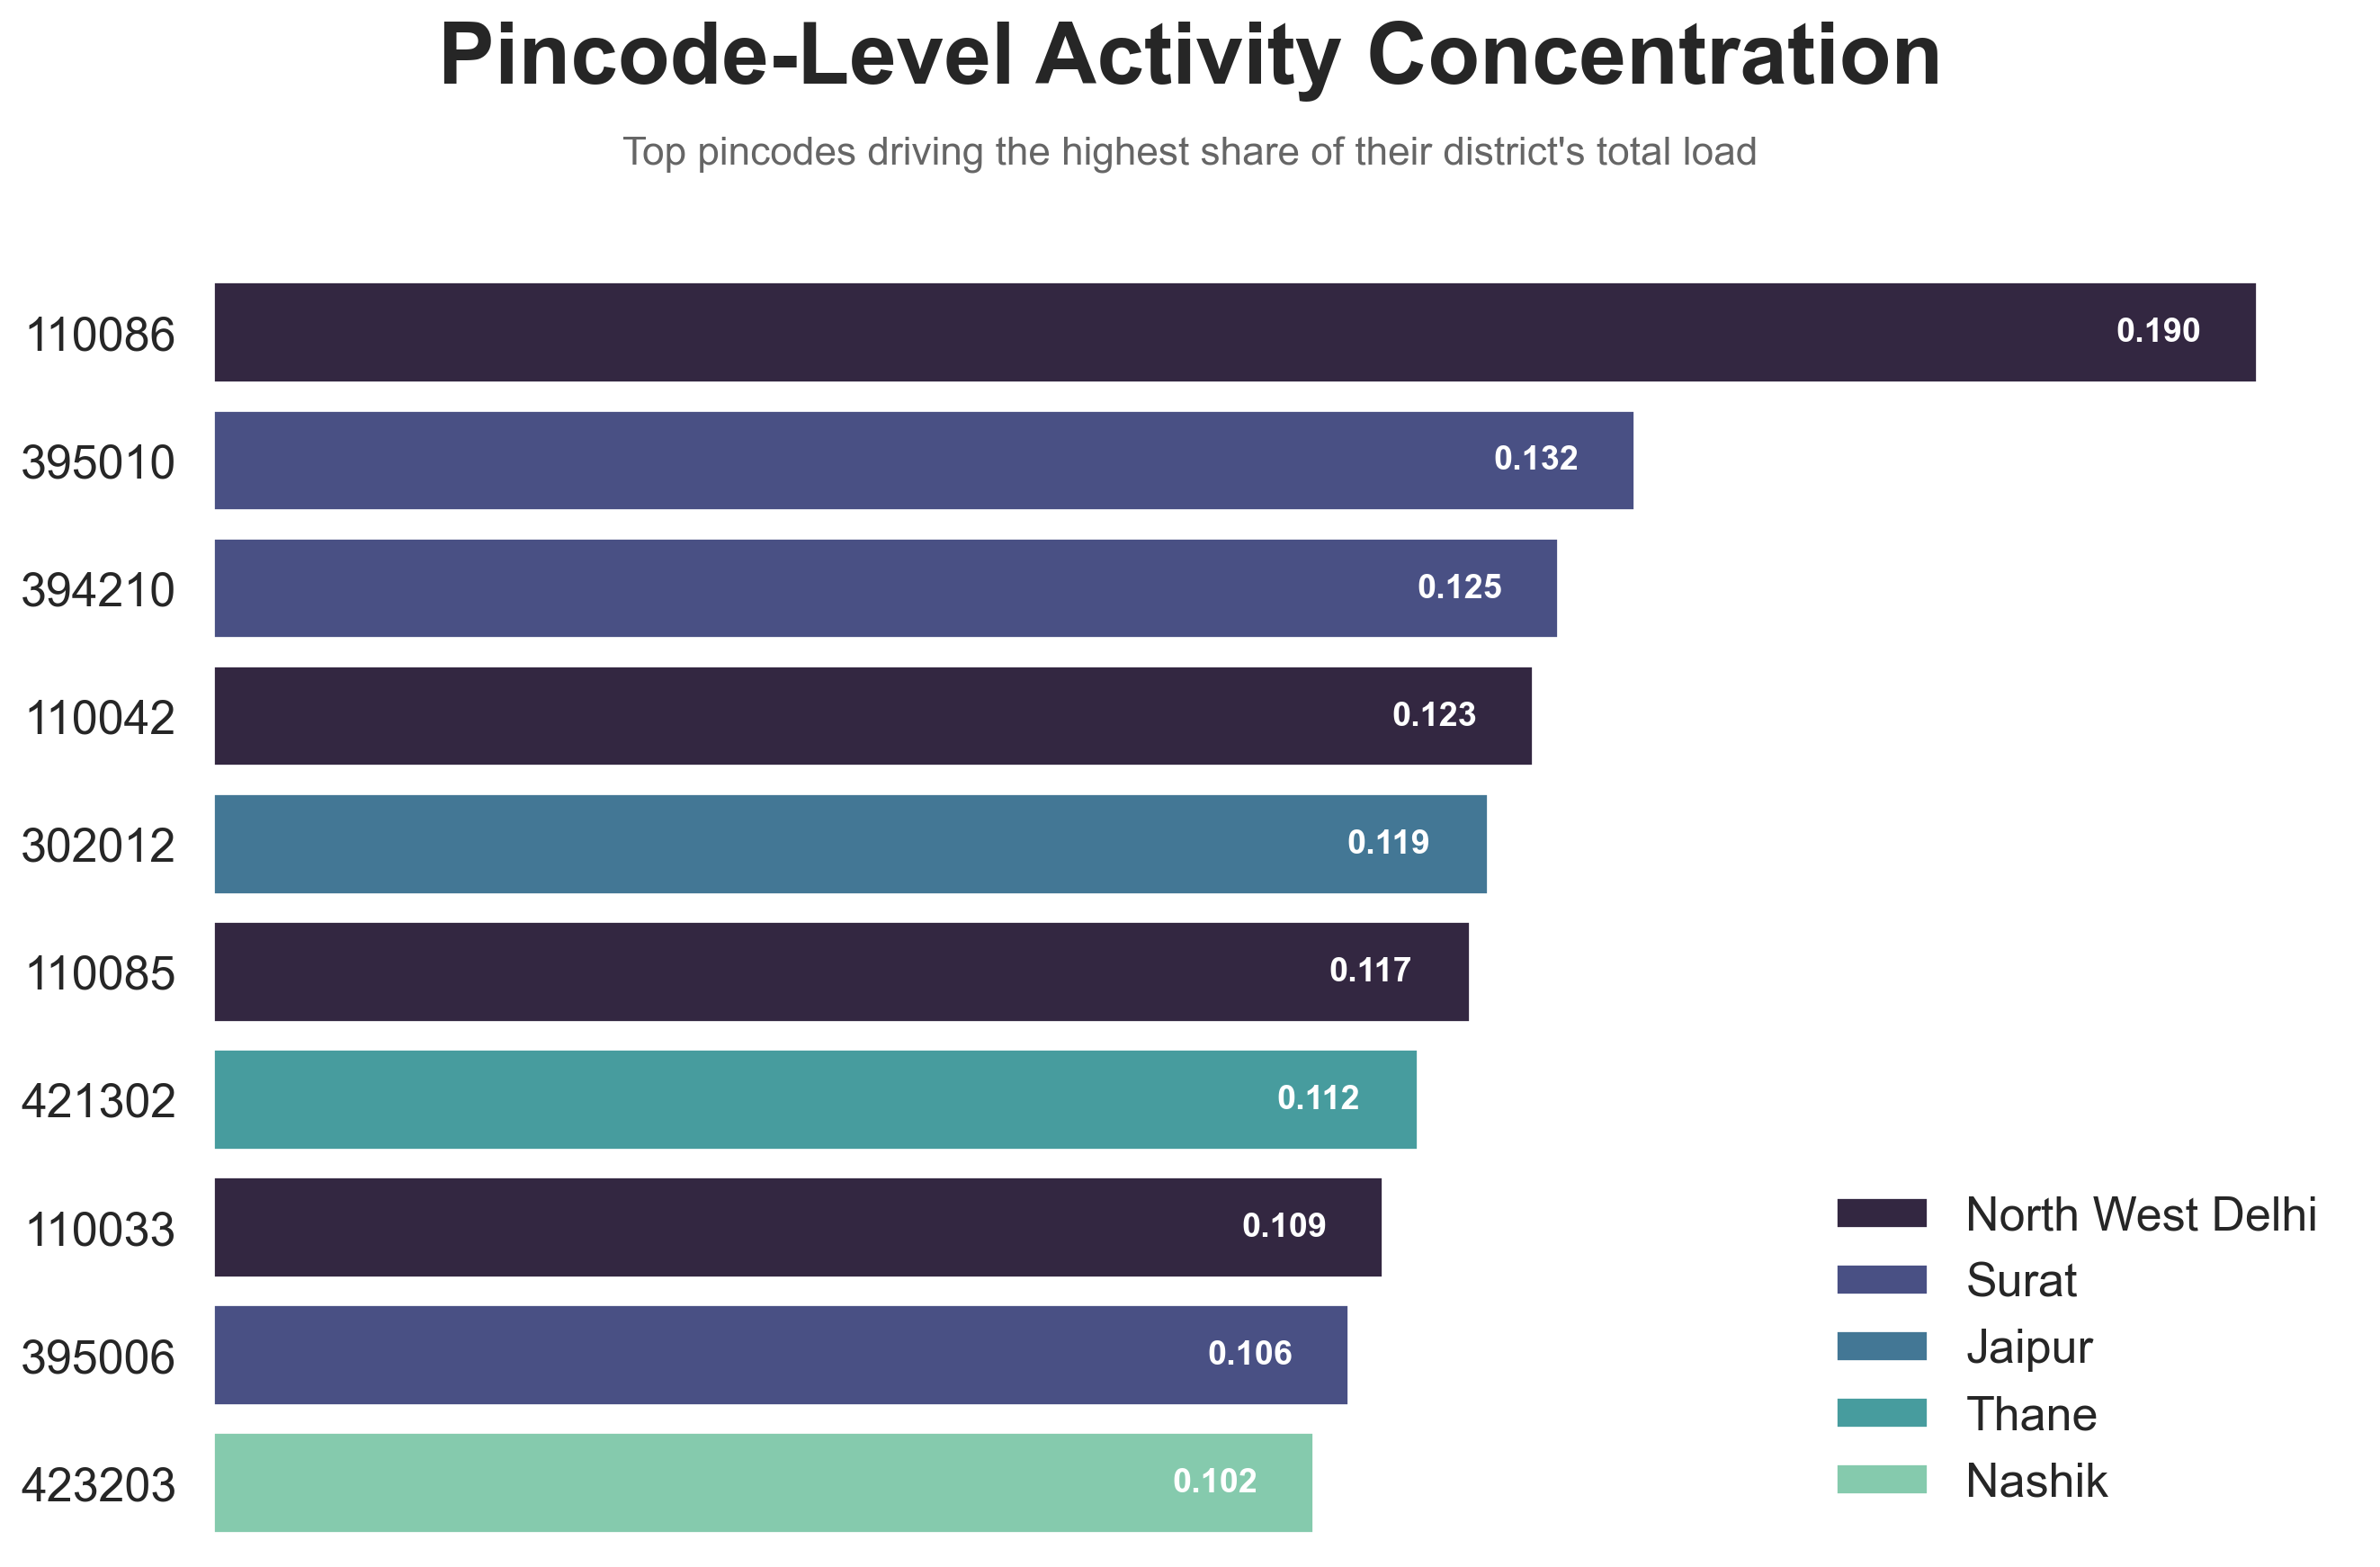

In [40]:
sns.set_context("talk")
sns.set_style("white")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 227

# 1. PREPARE & SORT THE DATA
top_pins_clean = gravity_pincodes.head(10).copy()
top_pins_clean = top_pins_clean.sort_values("pincode_activity_share", ascending=False)

if 'pincode' in top_pins_clean.columns:
    top_pins_clean['pincode'] = top_pins_clean['pincode'].astype(str)

# 2. PLOT
ax = sns.barplot(
    data=top_pins_clean,
    y="pincode",
    x="pincode_activity_share",
    hue="district",
    palette="mako",
    dodge=False
)

# 3. TITLES (Center Aligned)
plt.figtext(0.5, 0.93, "Pincode-Level Activity Concentration", 
            fontsize=30, weight='bold', ha='center')

plt.figtext(0.5, 0.88, "Top pincodes driving the highest share of their district's total load", 
            fontsize=14, color='#666666', ha='center')

# 4. DATA LABELS
for container in ax.containers:
    # fmt='%.2f' is good, but %.0% (e.g., 19%) might be faster to read for judges
    ax.bar_label(container, fmt='%.3f', padding=-50, fontsize=12, color='white', weight='bold')

# 5. CLEANUP
plt.xlabel("")
plt.ylabel("")
plt.xticks([]) 
sns.despine(left=True, bottom=True)

# 6. LEGEND (Lower Right)
sns.move_legend(
    ax, "lower right",
    bbox_to_anchor=(1, 0),
    title="",
    frameon=False,
)

# 7. LAYOUT
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()

## Insight: Pincode-Level Concentration Effects

### Within high-load districts, Aadhaar activity is not evenly distributed across pincodes. A small number of pincodes account for a disproportionate share of total activity.

These pincodes act as local "gravity points" where:
- Service demand is highly concentrated
- Infrastructure stress is localized
- Small capacity upgrades can have outsized impact

This insight enables targeted, pincode-level operational planning
within already identified high-load districts.